In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import seaborn as sns
import imblearn
sns.set_context('poster')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from application import get_sql_dataset
from application import prepare_dataset

# Cells for EDA directly from SQL database

In [5]:
con = get_sql_dataset.connect_to_sql()

postgresql://nwespe@localhost/mimic


In [6]:
con = psycopg2.connect(database='mimic', user='nwespe', host='localhost')
cur = con.cursor()
cur.execute('SET search_path to mimiciii;') # + schema_name)

In [ ]:
sql_query = """
SELECT *
FROM group_ab_prescriptions;
"""
group_admit_scripts = pd.read_sql_query(sql_query, con)  # 

In [ ]:
group_admit_scripts.head()

In [ ]:
sql_query = """
SELECT *
FROM classified_ab_scripts;
"""
classified_ab_scripts = pd.read_sql_query(sql_query, con)  # 

In [ ]:
classified_ab_scripts.head()

In [ ]:
early_ab_scripts = classified_ab_scripts[classified_ab_scripts.day_prescribed < 4]

In [ ]:
consolidated_ab_scripts = early_ab_scripts.groupby(['subject_id', 'hadm_id', 'drug_group'], axis=1)

In [ ]:
ab_scripts_outcomes = classified_ab_scripts.merge(both_outcomes, on='hadm_id')

In [ ]:
ab_scripts_outcomes.head()

In [ ]:
ab_scripts_outcomes[(ab_scripts_outcomes.cdiff == 1) & (ab_scripts_outcomes.day_prescribed <=3)].drug_group.value_counts()

In [ ]:
ab_scripts_outcomes[(ab_scripts_outcomes.cdiff == 0) & (ab_scripts_outcomes.day_prescribed <=3)].drug_group.value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = LabelEncoder()
ab_cats = ab_scripts_outcomes.drug_group
ab_cats_encoded = encoder.fit_transform(ab_cats)

In [ ]:
encoder.classes_

In [ ]:
encoder = LabelEncoder()
ab_cats = classified_ab_scripts.drug_group
ab_cats_encoded = encoder.fit_transform(ab_cats)

encoder = OneHotEncoder()
ab_cats_1hot = encoder.fit_transform(ab_cats_encoded.reshape(-1, 1))

In [ ]:
ab_cats_1hot

In [ ]:
early_ab_scripts.head()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
def drug_groups_set(df, x): # where x is row from df
    # get drug_group from all rows where hadm_id matches
    all_groups = df[(df.hadm_id == x.hadm_id)].drug_group
    all_groups2 = all_groups.apply(pd.Series).stack().tolist()
    unique_group = set(all_groups2)
    return tuple(unique_group)


In [ ]:
drug_tuples = early_ab_scripts[['hadm_id', 'drug_group']]
drug_tuples['drug_group'] = early_ab_scripts.apply(lambda x: drug_groups_set(early_ab_scripts, x), axis=1)

In [ ]:
drugs = drug_tuples.drop_duplicates()

In [ ]:
drugs.drug_group.value_counts()

In [ ]:
drugs.head()

In [ ]:
cdiff_outcomes.head()

In [ ]:
labeled_data = cdiff_outcomes.merge(drugs, how='left', on='hadm_id') #.fillna(value='None')

In [ ]:
labeled_data.head()

In [ ]:
drugs_list = list(labeled_data.drug_group.values)

In [ ]:
type(drugs_list[0])

In [ ]:
drugs_nonans = [text if str(text) != 'nan' else ('None',) for text in drugs_list]

In [ ]:
drugs_nonans[:10]

In [ ]:
encoder = MultiLabelBinarizer()
ab_cats_encoded = encoder.fit_transform(drugs_nonans)

In [ ]:
ab_cats_encoded

In [ ]:
encoder.classes_.tolist()

In [ ]:
cdiff_outcomes.head()

In [ ]:
drug_class_per_day = classified_ab_scripts.groupby(['subject_id', 'hadm_id', 'day_prescribed'], axis=0)['drug_class'].aggregate(lambda x: tuple(x)).reset_index()

In [ ]:
drug_class_per_day.head()

In [ ]:
def cumulative_class_number(x): # where x is row from df
    # get drug_name tuples from all rows where hadm_id matches and day_prescribed is <= x.day_prescribed
    all_classes = drug_class_per_day[(drug_class_per_day.subject_id == x.subject_id) & 
                                     (drug_class_per_day.hadm_id == x.hadm_id) & 
                                     (drug_class_per_day.day_prescribed <= x.day_prescribed)].drug_class
    all_classes2 = all_classes.apply(pd.Series).stack().tolist()
    unique_drugs = set(all_classes2)
    return len(unique_drugs)


In [ ]:
drug_class_per_day['cumulative_number_classes'] = drug_class_per_day.apply(lambda x: cumulative_class_number(x), axis=1)

In [ ]:
drug_class_per_day.head()

In [ ]:
drug_class_per_day.to_csv('/Users/nwespe/Desktop/drug_class_per_day.csv')

In [ ]:
trimmed_scripts = classified_ab_scripts[['subject_id', 'hadm_id', 'day_prescribed', 'drug_name']]

In [ ]:
trimmed_scripts.head()

In [ ]:
trimmed_scripts.drug_name.value_counts()

In [ ]:
drugs_per_day = trimmed_scripts.groupby(['subject_id', 'hadm_id', 'day_prescribed'], axis=0).aggregate(lambda x: tuple(x)).reset_index()

In [ ]:
drugs_per_day.head() # .day_prescribed.value_counts() 

In [ ]:
data = drugs_per_day[(drugs_per_day.day_prescribed > 0) & (drugs_per_day.day_prescribed < 11)].day_prescribed
#bins = np.linspace(1, 11, 11)
plt.hist(data, bins=bins)

In [ ]:
def cumulative_number(x): # where x is row from df
    # get drug_name tuples from all rows where hadm_id matches and day_prescribed is <= x.day_prescribed
    all_names = drugs_per_day[(drugs_per_day.subject_id == x.subject_id) & (drugs_per_day.hadm_id == x.hadm_id) & (drugs_per_day.day_prescribed <= x.day_prescribed)].drug_name
    all_names2 = all_names.apply(pd.Series).stack().tolist()
    unique_drugs = set(all_names2)
    return len(unique_drugs)


In [ ]:
drugs_per_day['cumulative_number'] = drugs_per_day.apply(lambda x: cumulative_number(x), axis=1)

In [ ]:
drugs_per_day.head()

In [ ]:
drugs_per_day.to_csv('/Users/nwespe/Desktop/drugs_per_day.csv')

In [ ]:
cumulative_drug_class = drug_class_per_day.drop(['drug_class'], axis=1)
cumulative_drug_class = cumulative_drug_class.groupby(['subject_id', 'hadm_id'])['cumulative_number_classes'].max().reset_index()
cumulative_drug_class.head()

In [ ]:
drugs_outcomes = cumulative_drug_class.merge(both_outcomes, on='hadm_id')

In [ ]:
drugs_outcomes.head()

In [ ]:
#sns.lmplot(, y='', data=cumulative_drugs)
#f, ax = plt.subplots(figsize=(8, 8))
#ax.set_aspect("equal")

# Draw the two density plots
# ax = 
g = sns.FacetGrid(drugs_outcomes, row="cdiff", col="expire", margin_titles=True, sharey=True)
#bins = np.linspace(0, 24, 12)
g.map(sns.kdeplot, 'cumulative_number', bw=0.5) #, bins=bins, lw=0
#sns.violinplot(x='flag', y='cumulative_number', data=drugs_outcomes)
                  #hospital_expire_
                 #cmap="Reds", shade=True, shade_lowest=False)

In [ ]:
g = sns.FacetGrid(drugs_outcomes, row="cdiff", col="expire", margin_titles=True, sharey=True)
#bins = np.linspace(0, 24, 12)
g.map(sns.kdeplot, 'cumulative_number_classes', bw=0.5) #, bins=bins, lw=0

In [ ]:
sql_query = """
SELECT *
FROM ab_prescriptions;
"""
admit_scripts = pd.read_sql_query(sql_query, con)  # 

In [ ]:
admit_scripts[admit_scripts.subject_id == 54642]

In [ ]:
admit_scripts['admitdate'] = [d.date() for d in admit_scripts['admittime']]
admit_scripts['admitdate'] = admit_scripts['admitdate'].apply(lambda x: datetime64(x))
admit_scripts['time_to_prescription'] = admit_scripts['startdate'] - admit_scripts['admitdate']

In [ ]:
sql_query = """
SELECT me.hadm_id, me.org_name, me.charttime, ai.admittime
, ROUND( (CAST(EXTRACT(epoch FROM me.charttime - ai.admittime)/(60*60*24) AS numeric)), 4) AS cdiff_timelag
FROM microbiologyevents me
JOIN admit_info ai ON ai.hadm_id = me.hadm_id
WHERE me.org_name ILIKE '%DIFF%';"""
hadm_ids = tuple(outcome_ids)
#AND ai.hadm_id IN %s
cdiff_outcomes_times = pd.read_sql_query(sql_query, con) #cur.execute(sql_query);
#all_cdiff_pts = pd.read_sql_query(sql_query, con)
#JOIN mimiciii.admit_info ai ON ai.hadm_id = me.hadm_id  (hadm_ids,)

In [10]:
sql_query = """
SELECT ai.subject_id, ai.hadm_id, ai.admittime, dia.icd9_code, dia.seq_num
FROM admissions ai
JOIN diagnoses_icd dia ON ai.hadm_id = dia.hadm_id
WHERE dia.icd9_code = '00845';"""

cdiff_patients = pd.read_sql_query(sql_query, con) #cur.execute(sql_query);


In [11]:
cdiff_patients.head()

,subject_id,hadm_id,admittime,icd9_code,seq_num
0,21,111970,2135-01-30 20:50:00,00845,9
1,195,118936,2167-11-29 16:25:00,00845,4
2,243,129066,2140-02-16 14:40:00,00845,4
3,256,153771,2166-07-21 23:38:00,00845,1
4,395,137967,2127-06-16 01:33:00,00845,2


In [12]:
len(cdiff_patients)

1444

In [13]:
len(cdiff_patients[cdiff_patients.seq_num != 1])

1295

In [14]:
cdiff_ids = list(cdiff_patients.hadm_id.values)

In [17]:
sql_query = """
SELECT ai.subject_id, ai.hadm_id, ai.admittime, dia.icd9_code, dia.seq_num
FROM admissions ai
JOIN diagnoses_icd dia ON ai.hadm_id = dia.hadm_id
WHERE dia.seq_num = 1
AND ai.hadm_id IN %s;"""
hadm_ids = tuple(cdiff_ids)

cdiff_pts_primary_code = cur.execute(sql_query, (hadm_ids,))

#cdiff_patients = pd.read_sql_query(sql_query, con) #cur.execute(sql_query);


In [16]:
cdiff_pts_primary_code.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [18]:
cdiff_ids[:10]

[111970,
 118936,
 129066,
 153771,
 137967,
 109185,
 152166,
 100262,
 114791,
 120522]

In [ ]:
cdiff_outcomes_times.cdiff_timelag.mean()

In [ ]:
len(hadm_ids) #[:3]

In [ ]:
myset_cdiff_times = cdiff_outcomes_times[cdiff_outcomes_times.hadm_id.isin(hadm_ids)]

In [ ]:
times = myset_cdiff_times.cdiff_timelag.dropna()
bins=np.linspace(0, 20, 8)
plt.hist(times, bins=bins)

In [ ]:
times.median(), times.mean()

In [ ]:
len(cdiff_ids)

In [ ]:
cdiff_outcomes.flag.value_counts()

# now I want to figure out how many cdiff patients died in hospital

In [ ]:
infection_num_features = pd.read_sql_query('SELECT * FROM infection_num_features;', con)

In [ ]:
infection_num_features.head()

In [ ]:
all_outcomes = pd.read_sql_query('SELECT * FROM infection_outcomes;', con)
cdiff_outcomes = pd.read_sql_query('SELECT * FROM cdiff_outcomes;', con)

In [ ]:
both_outcomes = all_outcomes.merge(cdiff_outcomes, on='hadm_id')
both_outcomes.flag = both_outcomes.flag.astype(int)
both_outcomes.rename(columns = {'hospital_expire_flag':'expire', 'flag':'cdiff'}, inplace = True)

In [ ]:
both_outcomes.head()

In [ ]:
num_features_outcomes = cdiff_data.merge(all_outcomes, on='hadm_id')

In [ ]:
num_features_outcomes.rename(columns = {'hospital_expire_flag':'expire', 'outcome':'cdiff'}, inplace = True)

In [ ]:
num_features_outcomes.head()

In [ ]:
g = sns.FacetGrid(admit_info_cdiff, row="flag", col="hospital_expire_flag", margin_titles=True, sharey=False)
bins = np.linspace(0, 24, 12)
g.map(plt.hist, "admittimeonly", bins=bins, lw=0) #

# Create table of multiple stays, combine stays within 30 days

In [ ]:
admit_info = pd.read_sql_query('SELECT * FROM admit_info;', con)

In [ ]:
admit_info.head()

In [ ]:
info_subset = admit_info.loc[:, ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'los_hospital', 'icd9_code', 'hospstay_seq']]
multistays = info_subset[info_subset.hospstay_seq > 1]

In [ ]:
multistays.head()

In [ ]:
multistay_subids = set(multistays.subject_id)

In [ ]:
multistay_data.to_csv('/Users/nwespe/Desktop/multistay_combined_data.csv')

In [ ]:
outcomes.head()

In [ ]:
outcomes.remove.value_counts(), outcomes.flag.value_counts()

In [ ]:
multistay_data['outcome'].value_counts()

In [ ]:
culled_outcomes = outcomes[outcomes.remove == False]

In [ ]:
culled_outcomes.head()

In [ ]:
admit_info = pd.read_sql_query('SELECT * FROM admit_info;', con)
non_cdiff_admits = admit_info[admit_info.icd9_code != '00845']  # only include this subset from outcomes list
ids = list(non_cdiff_admits.hadm_id)
noncdiff_admit_outcomes = merged_outcomes[merged_outcomes.hadm_id.isin(ids)]

In [ ]:
noncdiff_admit_outcomes.head()

In [ ]:
len(noncdiff_admit_outcomes), noncdiff_admit_outcomes.new_flag.value_counts()

In [ ]:
cdiff_admits.head()

In [ ]:
cdiff_admits.hospstay_seq.value_counts()

In [ ]:
non_cdiff_admits = admit_info[admit_info.icd9_code != '00845']

In [ ]:
non_cdiff_admits.hospstay_seq.value_counts()

In [ ]:
shape(cdiff_admits)

In [ ]:
cdiff_admits.hospital_expire_flag.value_counts()

In [ ]:
admit_info_subset = admit_info.loc[:, ['hadm_id', 'los_hospital']]
all_info = num_features_outcomes.merge(admit_info_subset, on='hadm_id')

In [ ]:
all_info.head()

In [ ]:
all_info.expire[(all_info.cdiff == 1)].value_counts()

In [ ]:
all_info.expire[(all_info.cdiff == 0)].value_counts()

In [ ]:
all_surviving_pts = all_info[all_info.expire == 0]

In [ ]:
all_surviving_pts.head()

In [ ]:
g = sns.FacetGrid(all_surviving_pts, col='cdiff', margin_titles=True, sharey=False)
bins = np.linspace(0, 100, 20)
g.map(plt.hist, 'los_hospital', bins=bins) # , , lw=0

In [ ]:
all_surviving_pts.groupby(['cdiff'], axis=0)['los_hospital'].aggregate('mean')

# Cells for getting AB prescription information

In [ ]:
sql_query = """
SELECT pr.*, ai.icd9_code
FROM mimiciii.admit_info ai
JOIN prescriptions pr ON ai.hadm_id = pr.hadm_id
WHERE pr.drug ILIKE '%zolid%'
AND pr.drug_type = 'MAIN';
"""
prescriptions = pd.read_sql_query(sql_query, con)

In [ ]:
prescriptions.head()

In [ ]:
unique(prescriptions.drug)

In [ ]:
all_infect_prescriptions.head()

In [ ]:
shape(all_infect_prescriptions)

In [ ]:
sql_query = """
SELECT pr.*, ia.*
FROM mimiciii.infection_admits ia
LEFT JOIN mimiciii.prescriptions pr ON ia.hadm_id = pr.hadm_id
WHERE pr.drug_type = 'MAIN';
"""
infection_prescriptions = pd.read_sql_query(sql_query, con)

# Cells to prepare dataset for running model

In [240]:
all_features, cdiff_data, outcomes = get_sql_dataset.main()

postgresql://nwespe@localhost/mimic
Retrieved data from SQL, have outcomes of length: 7331
Flag value counts: False    6927
True      404
Name: flag, dtype: int64
Removed expired, now have outcomes:5911
Flag value counts: False    5598
True      313
Name: flag, dtype: int64
Merged close hospital stays, now have outcomes: 5683
Flag value counts: False    5376
True      307
Name: flag, dtype: int64
Removed admits for cdiff, now have outcomes: 5565
Flag value counts: False    5340
True      225
Name: flag, dtype: int64
Combined features with outcomes, now have data of length: 5434
Flag value counts: 0    5214
1     220
Name: outcome, dtype: int64
Adjusted data values for age, admission time
Flag value counts: 0    5214
1     220
Name: outcome, dtype: int64


In [8]:
bal_data = prepare_dataset.balance_dataset(cdiff_data, 'outcome')

In [ ]:
get_sql_dataset.plot_feature_counts(cdiff_data)

In [ ]:
get_sql_dataset.plot_feature_counts(bal_data)

In [ ]:
get_sql_dataset.plot_features(bal_data, save=True)

In [ ]:
get_sql_dataset.plot_correlations(cdiff_data)

# Cells for running a model and evaluating it

In [54]:
from application import run_model

In [242]:
x_train, y_train, x_test, y_test = prepare_dataset.main(cdiff_data, add_ab=False)

Selected features and dropped low-feature rows, now have dataset of length: 5424
Flag value counts: 0    5204
1     220
Name: outcome, dtype: int64


In [243]:
shape(x_train)

(352, 44)

In [244]:
x_test.head()

,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,...,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean,weight,height,bmi,age
0,-0.240033,-1.197083,1.140093,-0.282794,-0.127692,-0.546985,-0.583878,0.038204,0.244362,0.739393,...,0.722888,0.718566,0.721095,-0.352874,-0.352874,-0.352874,1.511679,0.607158,1.467988,-1.961749
1,-0.974742,-1.385228,1.688442,1.173053,-0.083465,-0.720756,0.005864,-0.723511,-1.299251,-1.399782,...,0.019452,0.015579,0.017524,0.228233,0.228233,0.228233,-0.602336,-0.597076,-0.780479,-0.087746
2,5.882547,0.007438,1.050544,-2.830526,-0.348826,0.379796,-2.647973,13.998354,-0.001959,-0.544112,...,-0.730882,-0.734277,-0.732955,0.518787,0.518787,0.518787,0.404338,-1.904149,1.697116,-1.131745
3,-0.974742,-0.862978,-0.311229,1.355033,-0.393053,-0.373214,-0.289007,-0.737360,-0.609552,-0.924410,...,0.300826,0.296774,0.298952,0.373510,0.373510,0.373510,-0.011754,0.050444,-0.622549,-0.056524
4,0.004870,-2.255645,2.505740,-0.828737,-0.216145,0.148101,0.743041,0.232095,-0.182595,-0.258889,...,0.394617,0.390504,0.392761,0.518787,0.518787,0.518787,1.598924,0.150556,1.880405,-1.676028


In [245]:
x_test.to_csv('/Users/nwespe/Desktop/mostnum_features_x_test.csv')

In [246]:
curr_model = run_model.fit_model(x_train, y_train, model='logistic', save=False)

In [247]:
run_model.evaluate_model(x_train, y_train, curr_model)

Cross validation metrics
CV Scores: [ 0.66666667  0.62360956  0.57735027  0.64549722  0.62360956  0.70710678
  0.72760688  0.64168895  0.59408853  0.61834694]
CV Mean: 0.642557136155
CV Standard deviation: 0.0446050201425
Accuracy: 0.585227272727
Classification report: 
             precision    recall  f1-score   support

          0       0.59      0.55      0.57       176
          1       0.58      0.62      0.60       176

avg / total       0.59      0.59      0.58       352

Confusion matrix results
False positives: 80
False negatives: 66


In [248]:
run_model.evaluate_model(x_test, y_test, curr_model)

Cross validation metrics
CV Scores: [ 0.83666003  0.70710678  0.63245553  0.63245553  0.79056942  0.8660254
  0.61237244  0.61237244  0.61237244  0.79056942]
CV Mean: 0.709295941274
CV Standard deviation: 0.0969498204829
Accuracy: 0.488636363636
Classification report: 
             precision    recall  f1-score   support

          0       0.49      0.48      0.48        44
          1       0.49      0.50      0.49        44

avg / total       0.49      0.49      0.49        88

Confusion matrix results
False positives: 23
False negatives: 22


In [250]:
prefix='mostnum'

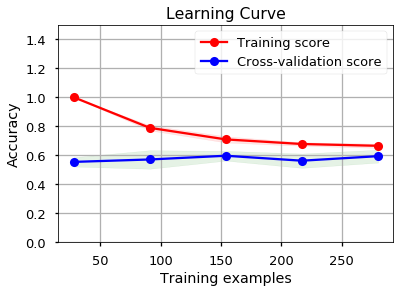

In [251]:
run_model.plot_learning_curve(curr_model, x_train, y_train, save=True, prefix=prefix)

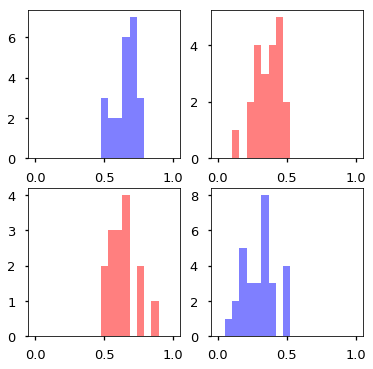

In [257]:
run_model.plot_probas(curr_model, x_test, y_test, save=False, prefix=prefix)

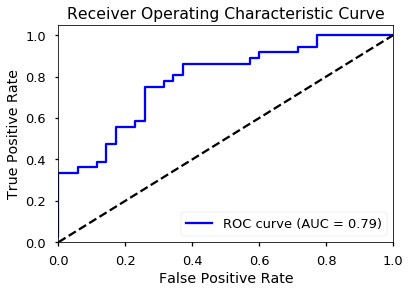

In [253]:
run_model.plot_roc_curve(curr_model, x_train, y_train, save=True, prefix=prefix)

Optimal number of features : 4


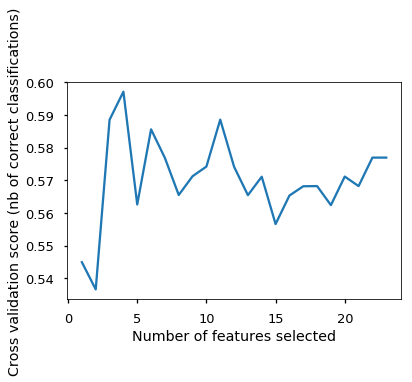

In [233]:
selector = run_model.recursive_feature(x_train, y_train)

In [234]:
selector.ranking_

array([14, 13,  2, 17, 11, 10,  9, 15, 18, 16, 20, 19,  3,  4,  6,  5,  7,
       12,  8,  1,  1,  1,  1])

In [235]:
ones = [i for i, v in enumerate(selector.ranking_) if v == 1]
[list(x_train.columns)[i] for i in ones]

['Moderate', 'None', 'Treatment', 'Unknown']

In [236]:
onetofour = [i for i, v in enumerate(selector.ranking_) if v < 5]
[list(x_train.columns)[i] for i in onetofour]

['bilirubin',
 'meanbp_mean',
 'weight',
 'Moderate',
 'None',
 'Treatment',
 'Unknown']

# Cells for feature importance and selection

In [254]:
coefs = np.around(curr_model.coef_, 3)
coefs.reshape(-1)
std = x_train.std(axis=0)
std_coef_series = pd.Series(np.reshape(np.array(std)*coefs, -1), index=std.index)

In [255]:
feature_importance_df = pd.DataFrame(data=[std, std_coef_series])
model_feature_importance = feature_importance_df.loc[1].sort_values()

In [256]:
model_feature_importance

hemoglobin       -0.832183
diasbp_min       -0.719022
meanbp_max       -0.605861
chloride         -0.444632
weight           -0.429611
resprate_min     -0.421599
sysbp_min        -0.301428
bicarbonate      -0.283403
bilirubin        -0.260370
tempc_min        -0.244347
pt               -0.211300
albumin          -0.119169
meanbp_mean      -0.115164
aniongap         -0.104148
resprate_mean    -0.097138
bands            -0.068097
glucose          -0.046065
spo2_max         -0.029041
spo2_mean        -0.029041
spo2_min         -0.029041
ptt              -0.024034
sysbp_mean       -0.013019
creatinine       -0.012017
potassium         0.006009
heartrate_mean    0.008011
heartrate_max     0.008011
heartrate_min     0.008011
diasbp_mean       0.025036
lactate           0.027038
tempc_mean        0.027038
platelet          0.073104
age               0.075107
sodium            0.108154
bmi               0.114162
wbc               0.175249
height            0.193275
inr               0.216307
r

In [49]:
model_feature_importance.to_csv('/Users/nwespe/Desktop/all_feature_scaled_survived_cdiff_feature_importance.csv')

Top feature correlations with outcome: 
outcome     1.000000
bun         0.055022
aniongap    0.038807
Name: outcome, dtype: float64
albumin       -0.050216
meanbp_mean   -0.050925
meanbp_min    -0.052021
Name: outcome, dtype: float64
<a list of 0 Text xticklabel objects>


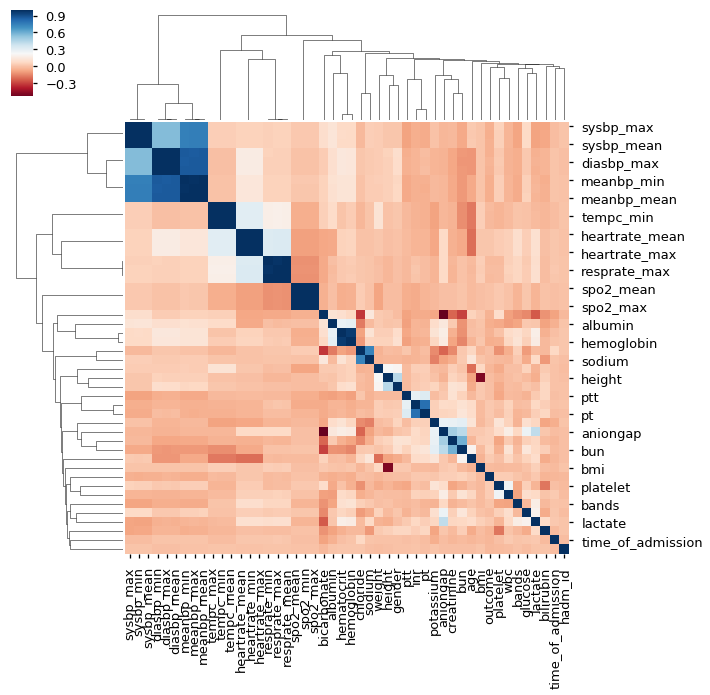

In [176]:
get_sql_dataset.plot_correlations(cdiff_data)

In [ ]:
y_test.iloc[661]

In [ ]:
X_df = pd.DataFrame(X, columns=test_df.columns)
profile = X_df.sample(n=1)

In [ ]:
profile = np.around(profile, decimals=1)

In [ ]:
profile.transpose()

In [ ]:
test_df.head()

In [ ]:
#result = run_model.eval_risk()

In [ ]:
check_data = X_df.iloc[:20]
check_outcomes = y_train.iloc[:20]
predictions = log_reg.predict(check_data)
#check_data_prepared = num_pipeline.transform(check_data)
print "Predictions:" + str(predictions)

In [ ]:
print log_reg.coef_

In [ ]:
log_mse = mean_squared_error(check_outcomes, predictions)
log_rmse = np.sqrt(log_mse)

In [ ]:
log_rmse

In [ ]:
check_outcomes.values

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_df, y_train)

In [ ]:
check_data = X_df.iloc[:20]
check_outcomes = y_train.iloc[:20]
predictions = tree_reg.predict(check_data)
#check_data_prepared = num_pipeline.transform(check_data)
print "Predictions:" + str(predictions)

In [ ]:
tree_mse = mean_squared_error(check_outcomes, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(tree_reg, X_df, y_train, scoring='neg_mean_squared_error', cv=10)

In [ ]:
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print 'Scores:' + str(scores)
    print 'Mean:' + str(scores.mean())
    print 'Standard deviation:' + str(scores.std())

In [ ]:
display_scores(tree_rmse_scores)

In [ ]:
scores = cross_val_score(log_reg, X_df, y_train, scoring='neg_mean_squared_error', cv=10)
log_rmse_scores = np.sqrt(-scores)

In [ ]:
display_scores(log_rmse_scores)

In [ ]:
missing_mask = np.ma.getmaskarray(np.ma.masked_invalid(x_train))
knn_mse = ((X_filled_knn[missing_mask] - np.array(X_df)[missing_mask]) ** 2).mean()
print("knnImpute MSE: %f" % knn_mse)

In [ ]:
sql_query = """
SELECT c.*
FROM chartevents c
WHERE c.hadm_id = 170249
AND c.itemid IN (226512, 226531);  
"""
see_items = pd.read_sql_query(sql_query, con)
see_items 
#LIKE '%icarb%'

In [ ]:
sql_query = """
SELECT dl.itemid, dl.label, dl.fluid, dl.category
FROM d_labitems dl
WHERE dl.itemid IN (50803, 50804, 50882);  
"""
see_items = pd.read_sql_query(sql_query,con)
see_items 

In [ ]:
sql_query = """
SELECT pr.drug, pr.drug_type, pr.drug_name_poe, pr.drug_name_generic
FROM prescriptions pr
WHERE pr.drug LIKE '%cin';
"""
see_drugs = pd.read_sql_query(sql_query,con)
unique(see_drugs.drug)

In [ ]:
sql_query = """
SELECT * FROM diagnoses_icd;
"""
diagnoses = pd.read_sql_query(sql_query,con)

# need to get set of subject_id's associated with one or more icd codes whose 
# first 3 digits are lower than 140
# first remove rows with codes starting with V or E

diagnoses['icd9_letter'] = diagnoses.icd9_code.str[0]
diagnoses = diagnoses[(diagnoses.icd9_letter != 'E') & (diagnoses.icd9_letter != 'V')]
diagnoses['icd9_3digit'] = diagnoses.icd9_code.str[:3]
diagnoses.icd9_3digit = pd.to_numeric(diagnoses.icd9_3digit)
diagnoses.head()

In [ ]:
sql_query = """
CREATE VIEW infection_admissions AS 
SELECT * FROM admissions
WHERE hadm_id IN %s;"""
hadm_ids = tuple(infected_admits)

cur.execute(sql_query, (hadm_ids,))

In [ ]:
infection_admissions = pd.read_sql_query('SELECT * FROM infection_admissions',con)
infection_admissions.head()

In [ ]:
print infection_admissions.hospital_expire_flag.value_counts()
print infection_admissions.admission_location.value_counts()

In [ ]:
subset['chartlag'] = (subset.charttime - subset.admittime) / np.timedelta64(1, 'h')

In [ ]:
early_charts = subset[subset.chartlag < 3]
early_charts.head()

In [ ]:
sql_query = """
SELECT ia.hadm_id, ia.subject_id, ia.admittime, pr.icustay_id, pr.startdate, 
ia.hospital_expire_flag, pr.drug
FROM infection_admissions ia
LEFT JOIN prescriptions pr ON ia.hadm_id = pr.hadm_id
WHERE pr.drug_type = 'MAIN';"""

prescriptions = pd.read_sql_query(sql_query, con)

In [ ]:
patients['age_at_death'] = (patients.dod - patients.dob)/np.timedelta64(1, 'Y')

In [ ]:
age_bins = [-300, 0, 18, 40, 50, 60 ,70, 80, 90, 100]
age_labels = ['exclude', 'youth', '18-39', '40-49', '50-59', '60-69', '70-79', '80-89', '>89']
age_categories = pd.cut(patients['age_at_death'], age_bins, labels=age_labels)
patients['age_category'] = pd.cut(patients['age_at_death'], age_bins, labels=age_labels)

In [ ]:
outcome = 'hospital_expire_flag'
feature = 'age_category'
db = infect_pts

g = sns.countplot(x=outcome, hue=feature, data=db)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Patient outcomes and age at death')
#plt.savefig('/Users/nwespe/Desktop/pt_expire_ethnicity.png', bbox_inches='tight')